![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FApplied+Autoencoders&file=Autoencoders+-+Data+To+Training.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Autoencoders/Autoencoders%20-%20Data%20To%20Training.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FApplied%2520Autoencoders%2FAutoencoders%2520-%2520Data%2520To%2520Training.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Autoencoders/Autoencoders%20-%20Data%20To%20Training.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/Applied%20Autoencoders/Autoencoders%20-%20Data%20To%20Training.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Autoencoders - Data To Training

How to retrieve data for training, and using, an autoencoder.

This workflow covers getting data to the location of training, in this case, many methods of getting BigQuery data into a Pandas DataFrame.  Then the dataframe is used as inputs for batches to TensorFlow with named inputs (columns).  Additionally, the TensorFlow I/O reader for BigQuery is used to directly read batches from BigQuery without the need to first load an entire dataframe.

---
Part of the [series **Applied Autoencoders Series**](https://github.com/statmike/vertex-ai-mlops/blob/main/Applied%20Autoencoders/readme.md)

A series of workflows focused on training and using autoencoders.  The series starts from the foundation of reading data efficiently and incrementally introduces concepts.

---

**Prerequisites**

[01 - BigQuery - Table Data Source](../../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb)

---
## Colab Setup

To run this notebook in Colab click [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/Applied%20Autoencoders/Autoencoders%20-%20Data%20To%20Training.ipynb) and run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    import google.colab
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
except Exception:
    pass

---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.bigquery', 'google-cloud-bigquery'),
    ('google.cloud.bigquery_storage', 'google-cloud-bigquery-storage'),
    ('bigframes', 'bigframes'),
    ('pandas_gbq', 'pandas-gbq'),
    ('tensorflow', 'tensorflow', '2.10'),
    ('tensorflow_io', '--no-deps tensorflow-io'),
    ('graphviz', 'graphviz'),
    ('pydot', 'pydot')
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

In [4]:
#!sudo apt-get -qq install graphviz

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

inputs:

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'data'
SERIES = 'applied-autoencoders'

# source data
BQ_PROJECT = PROJECT_ID
BQ_DATASET = 'fraud'
BQ_TABLE = 'fraud_prepped'

# specify a GCS Bucket
GCS_BUCKET = PROJECT_ID

# Model Training
VAR_TARGET = 'Class'
VAR_OMIT = 'transaction_id,splits' # add more variables to the string with comma delimiters

packages:

In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from google.cloud import bigquery
from google.cloud import bigquery_storage
import bigframes.pandas as bpd
import pandas as pd
import numpy as np
import concurrent.futures

from tensorflow.python.framework import dtypes
from tensorflow_io.bigquery import BigQueryClient
import tensorflow as tf

clients:

In [9]:
bq = bigquery.Client(project = PROJECT_ID)
bqstorage = bigquery_storage.BigQueryReadClient()
bpd.options.bigquery.project = PROJECT_ID

---
## Review Data

The data source here was prepared in [01 - BigQuery - Table Data Source](../01%20-%20Data%20Sources/01%20-%20BigQuery%20-%20Table%20Data%20Source.ipynb).  In this notebook we will use prepared BigQuery table as input for TensorFlow.

This is a table of 284,807 credit card transactions classified as fradulant or normal in the column `Class`.  In order protect confidentiality, the original features have been transformed using [principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) into 28 features named `V1, V2, ... V28` (float).  Two descriptive features are provided without transformation by PCA:
- `Time` (integer) is the seconds elapsed between the transaction and the earliest transaction in the table
- `Amount` (float) is the value of the transaction

The data preparation included added splits for machine learning with a column named `splits` with 80% for training (`TRAIN`), 10% for validation (`VALIDATE`) and 10% for testing (`TEST`).  Additionally, a unique identifier was added to each transaction, `transaction_id`.  

There is a target variable, `Class`, that represents the classification, but in the case of an autoencoder the training is not supervised to directly learn to classify.  For this reason the `Class` column will be omitted from the model training here in order to not overinform the reconstruction of the inputs.

Review the number of records for each level of the data splits:

In [10]:
query = f"""
    SELECT splits, count(*) as n
    FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
    GROUP BY splits
"""
print(query)


    SELECT splits, count(*) as n
    FROM `statmike-mlops-349915.fraud.fraud_prepped`
    GROUP BY splits



In [11]:
bq.query(query = query).to_dataframe()

,splits,n
0,TEST,28502
1,TRAIN,228061
2,VALIDATE,28244


---
## From BigQuery To Pandas DataFrame

A dataframe is a great input for TensorFlow for smaller tabular data sources.  The Panda dataframe can read data from many locations.  This section will cover multiple ways of retrieving data stored in BigQuery into a dataframe.

For larger sources see the later section that covers using the TensorFlow I/O reader for BigQuery.

### Common Query

A common SQL query to use for retrieval from BigQuery clients that use SQL (not the storage client). This selects all the columns other than the ones listed to omit above in `VAR_OMIT` while also subsetting to just the `splits = 'TRAIN'` rows.

In [12]:
query = f'''
SELECT * EXCEPT({','.join([VAR_TARGET] + VAR_OMIT.replace(' ', '').split(','))})
FROM `{BQ_PROJECT}.{BQ_DATASET}.{BQ_TABLE}`
WHERE splits = 'TRAIN'
'''
print(query)


SELECT * EXCEPT(Class,transaction_id,splits)
FROM `statmike-mlops-349915.fraud.fraud_prepped`
WHERE splits = 'TRAIN'



### BigQuery Cell Magic

When working in Jupyter notebooks, like here, using the IPython cell magic for BigQuery can be very helpful.
- [Reference](https://cloud.google.com/python/docs/reference/bigquery/latest/magics)

In [13]:
%%bigquery bq_data_magic
SELECT * EXCEPT(Class,transaction_id,splits)
FROM `statmike-mlops-349915.fraud.fraud_prepped`
WHERE splits = 'TRAIN'

Query is running:   0%|          |

Downloading:   0%|          |

In [14]:
bq_data_magic.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2812,-0.633403,0.963616,2.494946,2.099051,-0.404331,0.235862,-0.007932,0.211442,-0.209817,...,-0.174985,0.014676,0.016278,-0.061462,0.355196,-0.179086,-0.106947,-0.215039,0.050698,0.0
1,3150,1.313281,-0.257923,0.118463,-0.735557,-0.569308,-0.733577,-0.138659,-0.141641,1.708019,...,-0.145144,-0.082467,0.126066,-0.223157,-0.074977,0.921940,-0.528283,0.064476,0.013132,0.0
2,16676,1.158480,0.168947,0.536345,1.187908,-0.265547,-0.076325,-0.355844,0.144615,1.462346,...,-0.355289,0.016492,0.263518,-0.076711,-0.079402,0.502827,-0.270819,-0.004966,-0.003372,0.0
3,17701,-1.279231,-0.153303,3.296310,3.320441,1.139018,0.542343,-0.729928,-0.051774,0.922712,...,0.028639,-0.409746,-0.342575,-0.493297,-0.017046,-0.107404,0.101164,-0.197940,-0.435654,0.0
4,28131,1.069507,-0.000362,1.448936,2.874498,-0.736266,0.831932,-0.762267,0.406772,0.626473,...,-0.292305,0.035393,0.444433,-0.085413,0.099090,0.506438,0.246418,0.057864,0.021133,0.0


In [15]:
type(bq_data_magic)

pandas.core.frame.DataFrame

In [16]:
bq_data_magic.shape

(228061, 30)

### BigQuery Python Client

The Python Client for BigQuery makes executing queries in BigQuery from SQL as simple as passing the SQL query as a string.  This also means the query can be constructed locally in Python as it was above in the 'Common Query' section.  The results of queries can be directly retrieved to a local dataframe using the `to_dataframe()` method.
- [Reference](https://cloud.google.com/python/docs/reference/bigquery/latest)

In [17]:
bq_data_client = bq.query(query = query).to_dataframe()
bq_data_client.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2812,-0.633403,0.963616,2.494946,2.099051,-0.404331,0.235862,-0.007932,0.211442,-0.209817,...,-0.174985,0.014676,0.016278,-0.061462,0.355196,-0.179086,-0.106947,-0.215039,0.050698,0.0
1,3150,1.313281,-0.257923,0.118463,-0.735557,-0.569308,-0.733577,-0.138659,-0.141641,1.708019,...,-0.145144,-0.082467,0.126066,-0.223157,-0.074977,0.921940,-0.528283,0.064476,0.013132,0.0
2,16676,1.158480,0.168947,0.536345,1.187908,-0.265547,-0.076325,-0.355844,0.144615,1.462346,...,-0.355289,0.016492,0.263518,-0.076711,-0.079402,0.502827,-0.270819,-0.004966,-0.003372,0.0
3,17701,-1.279231,-0.153303,3.296310,3.320441,1.139018,0.542343,-0.729928,-0.051774,0.922712,...,0.028639,-0.409746,-0.342575,-0.493297,-0.017046,-0.107404,0.101164,-0.197940,-0.435654,0.0
4,28131,1.069507,-0.000362,1.448936,2.874498,-0.736266,0.831932,-0.762267,0.406772,0.626473,...,-0.292305,0.035393,0.444433,-0.085413,0.099090,0.506438,0.246418,0.057864,0.021133,0.0


In [18]:
type(bq_data_client)

pandas.core.frame.DataFrame

In [19]:
bq_data_client.shape

(228061, 30)

### BigQuery BigFrames Client

The BigFrames Client for BigQuery is new (2023) and allows references remote BigQuery tables as dataframe like object in local Python.  The dataframe functions are executed in BigQuery and results stored in temporary tables.  At any point a temporary table can be stored as a permanent table with the `.to_gbq()` method or even pulled fully to the Python execution environment as a local dataframe with the `.to_pandas()` method as demonstrated below.
- [Reference](https://cloud.google.com/python/docs/reference/bigframes/latest)

In [20]:
bq_data_bigframes = bpd.read_gbq(query)
bq_data_bigframes.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,117857,-0.34221,0.903781,0.556961,-0.195003,0.112991,-0.51582,0.811486,-0.554063,-1.763437,...,0.714474,-0.078788,0.108075,-0.290118,1.113121,0.447556,0.199248,-0.081135,-0.061349,40.0
1,56447,1.42638,-0.611825,0.16567,-0.898404,-0.671324,-0.14292,-0.756738,0.090045,-0.472077,...,-0.047684,-0.143361,-0.569391,0.082969,-0.838399,0.21394,-0.393502,0.015332,0.006712,6.18
2,26096,-4.254652,4.612257,-0.286959,-0.95134,0.979931,-0.953636,3.114519,-2.523468,5.570837,...,4.261157,-1.124268,0.597059,-0.133162,0.470766,0.230323,-0.678818,1.085622,-0.940805,1.79
3,125780,-0.345134,1.036943,-0.230124,-0.755815,0.374212,-0.506093,0.613336,0.387138,-0.522661,...,-0.064826,-0.17186,-0.48293,0.102741,-0.463138,-0.434558,0.151072,0.118073,0.021872,19.98
4,56861,-3.021637,-3.317537,1.372621,-2.25474,0.75967,0.605632,-2.111818,1.355714,-2.332184,...,0.281491,0.446124,0.429207,0.072856,-1.389918,0.079758,-0.127151,-0.002403,-0.410168,118.0


In [21]:
type(bq_data_bigframes)

bigframes.dataframe.DataFrame

In [22]:
bq_data_bigframes.shape

(228061, 30)

In [23]:
bq_data_bigframes = bq_data_bigframes.to_pandas()
type(bq_data_bigframes)

pandas.core.frame.DataFrame

In [24]:
bq_data_bigframes.shape

(228061, 30)

### BigQuery Storage Client

BigQuery storage is very efficient for retrieval with the BigQuery Storage Client.  All BigQuery permanent tables are stored in columar format with efficient blocks that also represent any clustering and partitioning used.  Retrieval from storage does not use the compute side of BigQuery and can be read directly from storage in multiple asynchronous streams.  Retrieval can also be shaped by selecting a subset of fields and setting row restrictions to filter which rows are returned.  
- [Reference](https://cloud.google.com/python/docs/reference/bigquerystorage/latest)

In [25]:
read_session = bqstorage.create_read_session(
    request = dict(
        parent = f'projects/{PROJECT_ID}',
        read_session = dict(
            table = f"projects/{BQ_PROJECT}/datasets/{BQ_DATASET}/tables/{BQ_TABLE}",
            data_format = bigquery_storage.types.DataFormat.ARROW,
            read_options = dict(
                row_restriction = "splits = 'TRAIN'",
                selected_fields = bq_data_bigframes.columns.tolist()
            )
        ),
        max_stream_count = 0
    )
)

In [26]:
len(read_session.streams)

1

In [27]:
def read_stream(stream):
    # setup a reader
    reader = bqstorage.read_rows(name = stream.name)
    # read rows from reader into a dataframe.  Note this is actually multiple operations - read and convert
    return reader.to_dataframe()


bq_data_storage = []
with concurrent.futures.ThreadPoolExecutor(max_workers = len(read_session.streams)) as executor:
    futures = {
        executor.submit(read_stream, stream): stream for stream in read_session.streams
    }
    for future in concurrent.futures.as_completed(futures):
        stream = futures[future]
        bq_data_storage.append(future.result())

In [28]:
len(bq_data_storage)

1

In [29]:
bq_data_storage[0].shape

(228061, 30)

In [30]:
bq_data_storage = pd.concat(bq_data_storage)
bq_data_storage.shape

(228061, 30)

In [31]:
type(bq_data_storage)

pandas.core.frame.DataFrame

In [32]:
bq_data_storage.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2812,-0.633403,0.963616,2.494946,2.099051,-0.404331,0.235862,-0.007932,0.211442,-0.209817,...,-0.174985,0.014676,0.016278,-0.061462,0.355196,-0.179086,-0.106947,-0.215039,0.050698,0.0
1,3150,1.313281,-0.257923,0.118463,-0.735557,-0.569308,-0.733577,-0.138659,-0.141641,1.708019,...,-0.145144,-0.082467,0.126066,-0.223157,-0.074977,0.921940,-0.528283,0.064476,0.013132,0.0
2,16676,1.158480,0.168947,0.536345,1.187908,-0.265547,-0.076325,-0.355844,0.144615,1.462346,...,-0.355289,0.016492,0.263518,-0.076711,-0.079402,0.502827,-0.270819,-0.004966,-0.003372,0.0
3,17701,-1.279231,-0.153303,3.296310,3.320441,1.139018,0.542343,-0.729928,-0.051774,0.922712,...,0.028639,-0.409746,-0.342575,-0.493297,-0.017046,-0.107404,0.101164,-0.197940,-0.435654,0.0
4,28131,1.069507,-0.000362,1.448936,2.874498,-0.736266,0.831932,-0.762267,0.406772,0.626473,...,-0.292305,0.035393,0.444433,-0.085413,0.099090,0.506438,0.246418,0.057864,0.021133,0.0


### Indirect BigQuery with `pandas-gbq`

When working with [Pandas](https://pandas.pydata.org/docs/user_guide/index.html#user-guide) the methods above show the client returning data to pandas dataframes.  This section will show a pandas mudule, [pandas-gbq](https://pandas-gbq.readthedocs.io/en/latest/) that wraps the BigQuery client so that pandas can retrieve BigQuery data to dataframes.

References:
- [Comparison of BigQuery Client with pandas-gbq](https://cloud.google.com/bigquery/docs/pandas-gbq-migration)

In [33]:
bq_data_pandasgbq = pd.read_gbq(query, project_id = PROJECT_ID)
bq_data_pandasgbq.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,2812,-0.633403,0.963616,2.494946,2.099051,-0.404331,0.235862,-0.007932,0.211442,-0.209817,...,-0.174985,0.014676,0.016278,-0.061462,0.355196,-0.179086,-0.106947,-0.215039,0.050698,0.0
1,3150,1.313281,-0.257923,0.118463,-0.735557,-0.569308,-0.733577,-0.138659,-0.141641,1.708019,...,-0.145144,-0.082467,0.126066,-0.223157,-0.074977,0.921940,-0.528283,0.064476,0.013132,0.0
2,16676,1.158480,0.168947,0.536345,1.187908,-0.265547,-0.076325,-0.355844,0.144615,1.462346,...,-0.355289,0.016492,0.263518,-0.076711,-0.079402,0.502827,-0.270819,-0.004966,-0.003372,0.0
3,17701,-1.279231,-0.153303,3.296310,3.320441,1.139018,0.542343,-0.729928,-0.051774,0.922712,...,0.028639,-0.409746,-0.342575,-0.493297,-0.017046,-0.107404,0.101164,-0.197940,-0.435654,0.0
4,28131,1.069507,-0.000362,1.448936,2.874498,-0.736266,0.831932,-0.762267,0.406772,0.626473,...,-0.292305,0.035393,0.444433,-0.085413,0.099090,0.506438,0.246418,0.057864,0.021133,0.0


In [34]:
type(bq_data_pandasgbq)

pandas.core.frame.DataFrame

In [35]:
bq_data_pandasgbq.shape

(228061, 30)

## From Pandas Dataframe To TensorFlow Dataset

The methods above read data to a Pandas dataframe that is local to this session.  This section shows how to make the dataframe ready for TensorFlow as a `tf.data` object.  More methods are [covered here](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe) in the TensorFlow tutorials.

### Features as a feature array:

The following constructs a reader that converts the feature columns into a feature array.  This can be helpful when all the columns have the same data type, however, it does require providing data in the same column order at serving time which could create difficulty.  For named inputs see the section that follows this one.

Make a copy of one of the dataframes above:

In [36]:
training_data = bq_data_storage.copy()

Setup a `tf.data` object to read the dataframe.  In this case, each row would be read as an array.

References:
    - [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
    - [Load a pandas DataFrame - A DataFrame as a dictionary](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#a_dataframe_as_a_dictionary)

In [37]:
training_reader_array = tf.data.Dataset.from_tensor_slices(training_data)

Setup and [iterator](https://docs.python.org/3/library/functions.html#iter) and review a return value from the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):

In [38]:
ds_iter = iter(training_reader_array)
next(ds_iter)

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([ 2.81200000e+03, -6.33402988e-01,  9.63616039e-01,  2.49494562e+00,
        2.09905099e+00, -4.04330673e-01,  2.35861580e-01, -7.93190515e-03,
        2.11441518e-01, -2.09816820e-01,  3.08297603e-01, -1.20499231e+00,
       -4.74707809e-01, -6.54063562e-01, -4.74599113e-01, -4.28417793e-01,
        5.36651482e-01, -3.80654617e-01,  2.86505393e-02, -6.87969434e-01,
       -1.74984760e-01,  1.46755278e-02,  1.62781766e-02, -6.14624729e-02,
        3.55196343e-01, -1.79085504e-01, -1.06947425e-01, -2.15039257e-01,
        5.06977952e-02,  0.00000000e+00])>

### Features as named inputs:

This approach maps each column to an input with the column name.  Basically, a dictionary of columns.  The additional step is casting the dataframe as a dictionary with `dict(df)`.  When columns have different data types or when they need to be named inputs to help with serving the model later.

Make a copy of one of the dataframes above:

In [39]:
training_data = bq_data_storage.copy()

Setup a `tf.data` object to read the dataframe.  In this case, cast the dataframe to a dictonary to preserve the column names in the inputs. Otherwise each row would be read as an array.

References:
    - [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
    - [Load a pandas DataFrame - A DataFrame as a dictionary](https://www.tensorflow.org/tutorials/load_data/pandas_dataframe#a_dataframe_as_a_dictionary)

In [40]:
training_reader = tf.data.Dataset.from_tensor_slices(dict(training_data))

Setup and [iterator](https://docs.python.org/3/library/functions.html#iter) and review a return value from the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):

In [41]:
ds_iter = iter(training_reader)
{key: value.numpy() for key, value in next(ds_iter).items()}

{'Time': 2812,
 'V1': -0.6334029882736469,
 'V2': 0.9636160386293929,
 'V3': 2.4949456217577497,
 'V4': 2.0990509863350297,
 'V5': -0.4043306727875379,
 'V6': 0.23586157953548997,
 'V7': -0.00793190515031739,
 'V8': 0.211441518482132,
 'V9': -0.20981682042808,
 'V10': 0.308297602896481,
 'V11': -1.20499230853772,
 'V12': -0.4747078092970429,
 'V13': -0.654063561632139,
 'V14': -0.474599113137004,
 'V15': -0.428417793384727,
 'V16': 0.5366514815446061,
 'V17': -0.380654616844995,
 'V18': 0.0286505393093891,
 'V19': -0.687969434192997,
 'V20': -0.174984760363205,
 'V21': 0.0146755277991034,
 'V22': 0.0162781765829899,
 'V23': -0.061462472923487,
 'V24': 0.35519634316361604,
 'V25': -0.17908550429831896,
 'V26': -0.10694742544378999,
 'V27': -0.21503925668538898,
 'V28': 0.0506977952270228,
 'Amount': 0.0}

### Formating Features With The Dataset

By building functions that format features the functions can be mapped to the input of the Dataset reader.  In this case a main function, `features_to_array`, will be used to add an input named `feature_array` that is an array of all the named feature inputs.

Build a function and compile it as a `tf.function` that creates a new input feature that is an array of all numeric features values. Also, cast columns to a common datatype as needed.

References:
- [tf.function](https://www.tensorflow.org/api_docs/python/tf/function)
- [Introduction to graphs and tf.function](https://www.tensorflow.org/guide/intro_to_graphs)

In [42]:
@tf.function
def features_to_array(x):
    y = {}
    y.update(x)
    feature_array = []
    for col in training_data.columns:
        if x[col].dtype != tf.float64:
            feature_array.append(tf.cast(x[col], tf.float64))
        else:
            feature_array.append(x[col])
    
    y['feature_array'] = feature_array
    return y

Use an iterator to return and review a value from the Dataset while [mapping](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) this function to each call:

In [43]:
ds_iter = iter(training_reader.map(features_to_array))
{key: value.numpy() for key, value in next(ds_iter).items()}

{'Time': 2812,
 'V1': -0.6334029882736469,
 'V2': 0.9636160386293929,
 'V3': 2.4949456217577497,
 'V4': 2.0990509863350297,
 'V5': -0.4043306727875379,
 'V6': 0.23586157953548997,
 'V7': -0.00793190515031739,
 'V8': 0.211441518482132,
 'V9': -0.20981682042808,
 'V10': 0.308297602896481,
 'V11': -1.20499230853772,
 'V12': -0.4747078092970429,
 'V13': -0.654063561632139,
 'V14': -0.474599113137004,
 'V15': -0.428417793384727,
 'V16': 0.5366514815446061,
 'V17': -0.380654616844995,
 'V18': 0.0286505393093891,
 'V19': -0.687969434192997,
 'V20': -0.174984760363205,
 'V21': 0.0146755277991034,
 'V22': 0.0162781765829899,
 'V23': -0.061462472923487,
 'V24': 0.35519634316361604,
 'V25': -0.17908550429831896,
 'V26': -0.10694742544378999,
 'V27': -0.21503925668538898,
 'V28': 0.0506977952270228,
 'Amount': 0.0,
 'feature_array': array([ 2.81200000e+03, -6.33402988e-01,  9.63616039e-01,  2.49494562e+00,
         2.09905099e+00, -4.04330673e-01,  2.35861580e-01, -7.93190515e-03,
         2.11441

Now test the Dataset reader with option that will be used, like:
- [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to limit the number of rows per call
- [map(lambda v: (v. v.pop('feature_array')))](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to turn the response into a tuple with the feature columns in the first element and the new 'feature_array' in the second element.

Use [take(1)](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) to limit the number of calls for batches to a single request.

In [44]:
for features, feature_array in training_reader.map(features_to_array).map(lambda v: (v, v.pop('feature_array'))).batch(2).take(1):
    print('features:\n',list(features.keys()))
    for feature in features.items():
        print(feature)
    print('feature array:\n', feature_array)

features:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
('Time', <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2812, 3150])>)
('V1', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63340299,  1.31328087])>)
('V2', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.96361604, -0.25792282])>)
('V3', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([2.49494562, 0.11846283])>)
('V4', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 2.09905099, -0.73555665])>)
('V5', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.40433067, -0.56930772])>)
('V6', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.23586158, -0.73357721])>)
('V7', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.00793191, -0.13865918])>)
('V8', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.21144152, -0.14164134])>)
('V9', 

## From BigQuery To TensorFlow Dataset With TensorFlow I/O

A highly effective way to read batches directly to [`tf.data.Dataset`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) objects from BigQuery storage.  This allows training to commence before all of the data source is read and does not require that the full data source be stored locally.

References:
- [TensorFlow I/O](https://www.tensorflow.org/io)
- [TensorFlow I/O BigQuery Reader](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery)

Retrieve the schema of the table using BigQuery [INFORMATION_SCHEMA.COLUMNS](https://cloud.google.com/bigquery/docs/information-schema-columns) view.

In [45]:
query = f'''
SELECT *
FROM {BQ_PROJECT}.{BQ_DATASET}.INFORMATION_SCHEMA.COLUMNS
WHERE TABLE_NAME = '{BQ_TABLE}'
    AND COLUMN_NAME NOT IN ('Class', 'transaction_id', 'splits')
'''
schema = bq.query(query).to_dataframe()

Review the unique data types from the table:

In [46]:
schema.data_type.unique().tolist()

['INT64', 'FLOAT64']

Create a dictionary that maps BigQuery data types to TensorFlow data type objects:

In [47]:
types = {
    'FLOAT64' : dtypes.float64,
    'INT64' : dtypes.int64
}

Create a `tf.data.Dataset` object to read the BigQuery table using [TensorFlow I/O BigQuery Reader Client](https://www.tensorflow.org/io/api_docs/python/tfio/bigquery/BigQueryClient):

In [48]:
training_reader_tfio = BigQueryClient().read_session(
    parent = f"projects/{PROJECT_ID}",
    project_id = BQ_PROJECT,
    table_id = BQ_TABLE,
    dataset_id = BQ_DATASET,
    selected_fields = [x for x in schema.column_name.tolist()],
    output_types = [types[x] for x in schema.data_type.tolist()],
    row_restriction = f"splits='TRAIN'",
    requested_streams = 3
).parallel_read_rows(sloppy = True, num_parallel_calls = tf.data.experimental.AUTOTUNE)
type(training_reader_tfio)

tensorflow.python.data.ops.interleave_op._ParallelInterleaveDataset

Setup and [iterator](https://docs.python.org/3/library/functions.html#iter) and review a return value from the [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):

In [49]:
ds_iter = iter(training_reader_tfio)
{key: value.numpy() for key, value in next(ds_iter).items()}

{'Amount': 0.0,
 'Time': 2812,
 'V1': -0.6334029882736469,
 'V10': 0.308297602896481,
 'V11': -1.20499230853772,
 'V12': -0.4747078092970429,
 'V13': -0.654063561632139,
 'V14': -0.474599113137004,
 'V15': -0.428417793384727,
 'V16': 0.5366514815446061,
 'V17': -0.380654616844995,
 'V18': 0.0286505393093891,
 'V19': -0.687969434192997,
 'V2': 0.9636160386293929,
 'V20': -0.174984760363205,
 'V21': 0.0146755277991034,
 'V22': 0.0162781765829899,
 'V23': -0.061462472923487,
 'V24': 0.35519634316361604,
 'V25': -0.17908550429831896,
 'V26': -0.10694742544378999,
 'V27': -0.21503925668538898,
 'V28': 0.0506977952270228,
 'V3': 2.4949456217577497,
 'V4': 2.0990509863350297,
 'V5': -0.4043306727875379,
 'V6': 0.23586157953548997,
 'V7': -0.00793190515031739,
 'V8': 0.211441518482132,
 'V9': -0.20981682042808}

### Formating Features With The Dataset

By building functions that format features the functions can be mapped to the input of the Dataset reader.  In this case a main function, `features_to_array`, will be used to add an input named `feature_array` that is an array of all the named feature inputs.

Build a function and compile it as a `tf.function` that creates a new input feature that is an array of all numeric features values. Also, cast columns to a common datatype as needed.

References:
- [tf.function](https://www.tensorflow.org/api_docs/python/tf/function)
- [Introduction to graphs and tf.function](https://www.tensorflow.org/guide/intro_to_graphs)

In [50]:
@tf.function
def features_to_array(x):
    y = {}
    y.update(x)
    feature_array = []
    for col in training_data.columns:
        if x[col].dtype != tf.float64:
            feature_array.append(tf.cast(x[col], tf.float64))
        else:
            feature_array.append(x[col])
    
    y['feature_array'] = feature_array
    return y

Use an iterator to return and review a value from the Dataset while [mapping](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) this function to each call:

In [51]:
ds_iter = iter(training_reader_tfio.map(features_to_array))
{key: value.numpy() for key, value in next(ds_iter).items()}

{'Amount': 0.0,
 'Time': 2812,
 'V1': -0.6334029882736469,
 'V10': 0.308297602896481,
 'V11': -1.20499230853772,
 'V12': -0.4747078092970429,
 'V13': -0.654063561632139,
 'V14': -0.474599113137004,
 'V15': -0.428417793384727,
 'V16': 0.5366514815446061,
 'V17': -0.380654616844995,
 'V18': 0.0286505393093891,
 'V19': -0.687969434192997,
 'V2': 0.9636160386293929,
 'V20': -0.174984760363205,
 'V21': 0.0146755277991034,
 'V22': 0.0162781765829899,
 'V23': -0.061462472923487,
 'V24': 0.35519634316361604,
 'V25': -0.17908550429831896,
 'V26': -0.10694742544378999,
 'V27': -0.21503925668538898,
 'V28': 0.0506977952270228,
 'V3': 2.4949456217577497,
 'V4': 2.0990509863350297,
 'V5': -0.4043306727875379,
 'V6': 0.23586157953548997,
 'V7': -0.00793190515031739,
 'V8': 0.211441518482132,
 'V9': -0.20981682042808,
 'feature_array': array([ 2.81200000e+03, -6.33402988e-01,  9.63616039e-01,  2.49494562e+00,
         2.09905099e+00, -4.04330673e-01,  2.35861580e-01, -7.93190515e-03,
         2.11441

Now test the Dataset reader with option that will be used, like:
- [batch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) to limit the number of rows per call
- [map(lambda v: (v. v.pop('feature_array')))](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to turn the response into a tuple with the feature columns in the first element and the new 'feature_array' in the second element.

Use [take(1)](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) to limit the number of calls for batches to a single request.

In [52]:
for features, feature_array in training_reader_tfio.map(features_to_array).map(lambda v: (v, v.pop('feature_array'))).batch(2).take(1):
    print('features:\n',list(features.keys()))
    for feature in features.items():
        print(feature)
    print('feature array:\n', feature_array)

features:
 ['Amount', 'Time', 'V1', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V2', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9']
('Amount', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([0., 0.])>)
('Time', <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2812, 3150])>)
('V1', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.63340299,  1.31328087])>)
('V10', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([ 0.3082976 , -1.10329377])>)
('V11', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-1.20499231, -1.08782009])>)
('V12', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47470781,  0.64467588])>)
('V13', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.65406356, -0.21536864])>)
('V14', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.47459911, -0.07471497])>)
('V15', <tf.Tensor: shape=(2,), dtype=float64, numpy=array([-0.42841779,  0.28787333])>)
('V16', <tf.T

## Training In TensorFlow

The following is a basic autoencoder model trained with TensorFlow.  The subsequent workflows in this series will expand this and describe it in more detail.

What is the shape of the `feature_array` from the Dataset?

In [53]:
ds_iter = iter(training_reader_tfio.map(features_to_array))
features = next(ds_iter)['feature_array']
features.numpy().size, features.dtype

(30, tf.float64)

Using the features as named inputs here:

In [54]:
feature_inputs = tf.keras.Input(shape = (features.numpy().size,), dtype = features.dtype, name = 'feature_array')

Define the models layers:

In [55]:
# encoder
encoder = tf.keras.layers.Dense(128, activation = tf.nn.relu, name = 'encoder_128')(feature_inputs)
encoder = tf.keras.layers.Dense(64, activation = tf.nn.relu, name = 'encoder_64')(encoder)
encoder = tf.keras.layers.Dense(8, activation = tf.nn.relu, name = 'encoder')(encoder)

# decoder
decoder = tf.keras.layers.Dense(64, activation = tf.nn.relu, name = 'decoder_64')(encoder)
decoder = tf.keras.layers.Dense(128, activation = tf.nn.relu, name = 'decoder_128')(decoder)
decoder = tf.keras.layers.Dense(feature_inputs.shape[1], activation = tf.nn.sigmoid, name = 'decoder')(decoder)

Group the layers into a model:

In [56]:
model = tf.keras.Model(
    inputs = feature_inputs,
    outputs = decoder,
    name = 'autoencoder'
)

Compile the model for training:

In [57]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(), #SGD or Adam
    loss = tf.keras.losses.MeanAbsoluteError(),
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(name = 'rmse'),
        tf.keras.metrics.MeanSquaredError(name = 'mse'),
        tf.keras.metrics.MeanAbsoluteError(name = 'mae'),
        tf.keras.metrics.MeanSquaredLogarithmicError(name = 'msle'),
    ]
)

Train the model:

In [58]:
model.fit(
    training_reader_tfio.prefetch(2).map(features_to_array).map(lambda v: (v['feature_array'], v['feature_array'])).shuffle(1000).batch(100),
    epochs = 2
)

Epoch 1/2
2281/2281 [==============================] - 15s 6ms/step - loss: 3163.8943 - rmse: 19360.3262 - mse: 374821856.0000 - mae: 3163.8943 - msle: 4.1957
Epoch 2/2
2281/2281 [==============================] - 13s 6ms/step - loss: 3163.8940 - rmse: 19360.3145 - mse: 374822016.0000 - mae: 3163.8940 - msle: 4.1808


Use the model for prediction:

In [59]:
for instance in training_reader_tfio.map(features_to_array).map(lambda v: v.pop('feature_array')).batch(1).take(1):
    print(instance)

tf.Tensor(
[[ 2.81200000e+03 -6.33402988e-01  9.63616039e-01  2.49494562e+00
   2.09905099e+00 -4.04330673e-01  2.35861580e-01 -7.93190515e-03
   2.11441518e-01 -2.09816820e-01  3.08297603e-01 -1.20499231e+00
  -4.74707809e-01 -6.54063562e-01 -4.74599113e-01 -4.28417793e-01
   5.36651482e-01 -3.80654617e-01  2.86505393e-02 -6.87969434e-01
  -1.74984760e-01  1.46755278e-02  1.62781766e-02 -6.14624729e-02
   3.55196343e-01 -1.79085504e-01 -1.06947425e-01 -2.15039257e-01
   5.06977952e-02  0.00000000e+00]], shape=(1, 30), dtype=float64)


In [60]:
instance = training_reader_tfio.map(features_to_array).map(lambda v: v.pop('feature_array')).batch(1).take(1)
for i in instance:
    print(i)

tf.Tensor(
[[ 2.81200000e+03 -6.33402988e-01  9.63616039e-01  2.49494562e+00
   2.09905099e+00 -4.04330673e-01  2.35861580e-01 -7.93190515e-03
   2.11441518e-01 -2.09816820e-01  3.08297603e-01 -1.20499231e+00
  -4.74707809e-01 -6.54063562e-01 -4.74599113e-01 -4.28417793e-01
   5.36651482e-01 -3.80654617e-01  2.86505393e-02 -6.87969434e-01
  -1.74984760e-01  1.46755278e-02  1.62781766e-02 -6.14624729e-02
   3.55196343e-01 -1.79085504e-01 -1.06947425e-01 -2.15039257e-01
   5.06977952e-02  0.00000000e+00]], shape=(1, 30), dtype=float64)


In [61]:
prediction = model.predict(instance)
prediction

1/1 [==============================] - 0s 328ms/step


array([[1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]],
      dtype=float32)

## Understanding the Model

The model trained above takes an input array of feature values and outputs the reconstructed values in an array of the same shape.

The subsequent workflows in this series will expand the model. To see an overview of the model created here use the `plot_model` and `summary` methods:

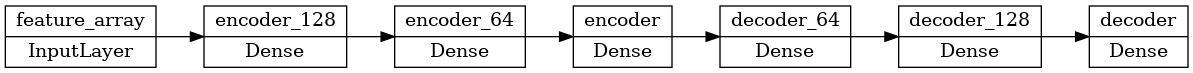

In [62]:
tf.keras.utils.plot_model(model, rankdir='LR')

In [63]:
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_array (InputLayer)  [(None, 30)]              0         
                                                                 
 encoder_128 (Dense)         (None, 128)               3968      
                                                                 
 encoder_64 (Dense)          (None, 64)                8256      
                                                                 
 encoder (Dense)             (None, 8)                 520       
                                                                 
 decoder_64 (Dense)          (None, 64)                576       
                                                                 
 decoder_128 (Dense)         (None, 128)               8320      
                                                                 
 decoder (Dense)             (None, 30)                